In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)


sparse_dir = os.path.join(project_dir, 'modules/Sparse')
if sparse_dir not in sys.path:
    sys.path.append(sparse_dir)

from matplotlib import pyplot as plt

# Dataset

In [2]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Subset, DataLoader

dataset_full = MNIST('data/', train = True, download = True, transform = transforms.ToTensor())
# idx = torch.where((dataset_full.targets == 0) | (dataset_full.targets == 2))[0]
normal_idx = torch.where((dataset_full.targets == 4))[0]
anomaly_idx = torch.where((dataset_full.targets == 9))[0]
idx = torch.cat([normal_idx, anomaly_idx[:512]])

x_train_set = Subset(dataset_full, idx)
train_loader =  DataLoader(x_train_set, 128, shuffle=True)

tensor(4)


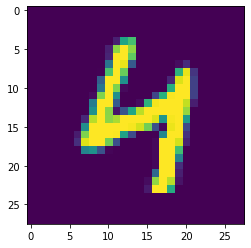

In [3]:
# TO REMOVE! Just testing!
x, y = next(iter(train_loader))
plt.imshow(x[0,0])
print(y[0])

In [17]:
torch.exp(torch.tensor(1)) / 2

tensor(1.3591)

In [23]:
torch.log(torch.tensor(0.1)), torch.exp(torch.tensor(-2.3026))



(tensor(-2.3026), tensor(0.1000))

In [5]:
from Sparse.modules.variational import VariationalLayer
from Sparse.modules.variational.utils import SGVBL
from torch.nn.parameter import Parameter
import torch.nn.functional as F

from torch import nn
class VariationalEncoder(nn.Linear, nn.Module):
    def __init__(self, in_features, out_features, bias=True) -> None:
        super(VariationalEncoder, self).__init__(in_features, out_features, bias)
        self.log_sigma_weight = Parameter(torch.Tensor(in_features, out_features))

        self.mu, self.sigma = None, None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        mu = F.linear(x, self.weight, self.bias)
        sigma = torch.exp(F.linear(x, self.log_sigma_weight))

        if self.training:
            self.mu, self.sigma = mu, sigma

        # Reparameterization trick
        eps = torch.normal(0, torch.ones_like(sigma))
        return mu + sigma * eps

    def kl_reg(self):
        # KL-Divergence regularization
        return .5 * (self.mu**2 + self.sigma**2 - torch.log(self.sigma**2) - 1).sum()

In [8]:
N = torch.distributions.Normal(0, 1)
N.loc = N.loc.cuda() # hack to get sampling on the GPU
N.scale = N.scale.cuda()

In [9]:
N

Normal(loc: 0.0, scale: 1.0)

In [ ]:
from torch import nn

def Encode(nn.Module):
    def __init__(self, input_size, latent_space):
        super(Encode, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,8, 3, stride=1, padding=1),
            nn.Dropout2d(0.5),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Conv2d(8, 16, 3, stride=1, padding=1),
            nn.Dropout2d(0.5),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Conv2d(16, 24, 3, stride=1, padding=1),
            nn.Dropout2d(0.5),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1),
        )

def Botleneck(nn.Module):
    def __init__(self, input_size, latent_space):
        super(Botleneck, self).__init__()
        self.z = nn.Sequential(
            nn.Linear(input_size, latent_space),
            nn.ReLU(),
            nn.Linear(latent_space, input_size),
            nn.ReLU()
        )



# z_size = input_size // (2*3)
# self.z = nn.Sequential(z_size, latent_space)

In [73]:
from torch import nn
test = nn.Sequential(
        nn.Conv2d(1,8, 3, stride=1, padding=1),
        nn.Dropout2d(0.5),
        nn.ReLU(),
        nn.MaxPool2d(3, stride=2, padding=1),
        nn.Conv2d(8, 16, 3, stride=1, padding=1),
        nn.Dropout2d(0.5),
        nn.ReLU(),
        nn.MaxPool2d(3, stride=2, padding=1),
        nn.Conv2d(16, 24, 3, stride=1, padding=1),
        nn.Dropout2d(0.5),
        nn.ReLU(),
        nn.MaxPool2d(3, stride=2, padding=1),
    )

x = torch.randn(1,1,28,28)
test(x).shape 

torch.Size([1, 24, 4, 4])

In [78]:
28//(2*3)

4

In [49]:
(28 + 2*1 - 3)/1 + 1 

28.0

In [72]:
8*14*14, 16*8*8, 24*4*4, 64*2*2, 128*1*1

(1568, 1024, 384, 256, 128)

In [57]:
28*28

784